![PyData_logo](./static/pydata-logo-madrid-2016.png)

# Remove Before Flight
## Analyzing Flight Safety Data with Python

###### Jesús Martos Carrizo
###### Alejandro Sáez Mollejo

### Loading & Cleaning data 

In [2]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl


In [3]:
# Some configuration options:
pd.set_option('max_columns', 70)
pd.set_option('max_rows', 50)

mpl.rcParams['figure.figsize'] = 10, 5
plt.style.use('ggplot')

##### A first glipse of the data: events

[Data base structure](./data/admsrel.pdf)

In [4]:
events = pd.read_csv("./data/events.csv", sep='|', low_memory=False)
events.head()

,ev_id,ntsb_no,ev_type,ev_date,ev_dow,ev_time,ev_tmzn,ev_city,ev_state,ev_country,ev_site_zipcode,ev_year,ev_month,mid_air,on_ground_collision,latitude,longitude,latlong_acq,apt_name,ev_nr_apt_id,ev_nr_apt_loc,apt_dist,apt_dir,apt_elev,wx_brief_comp,wx_src_iic,wx_obs_time,wx_obs_dir,wx_obs_fac_id,wx_obs_elev,wx_obs_dist,wx_obs_tmzn,light_cond,sky_cond_nonceil,sky_nonceil_ht,...,sky_cond_ceil,vis_rvr,vis_rvv,vis_sm,wx_temp,wx_dew_pt,wind_dir_deg,wind_dir_ind,wind_vel_kts,wind_vel_ind,gust_ind,gust_kts,altimeter,wx_dens_alt,wx_int_precip,metar,ev_highest_injury,inj_f_grnd,inj_m_grnd,inj_s_grnd,inj_tot_f,inj_tot_m,inj_tot_n,inj_tot_s,inj_tot_t,invest_agy,ntsb_docket,ntsb_notf_from,ntsb_notf_date,ntsb_notf_tm,fiche_number,lchg_date,lchg_userid,wx_cond_basic,faa_dist_office
0,20001208X07734,LAX97FA143,ACC,04/02/1997 12:00:00 AM,WE,2016.0,MST,GRAND CANYON,AZ,USA,86023,1997.0,4,N,N,,,NaN,,,OFAP,NaN,NaN,NaN,PARP,WFAC,1954.0,180.0,GCN,6606.0,21.0,MST,NDRK,SCAT,3600.0,...,BKN,"0,00000000e+00",0.0,"1,00000000e+01",-2.0,-3.0,0.0,U,0.0,CALM,N,0.0,"2,90000000e+01",NaN,UNK,NaN,FATL,0.0,0.0,0.0,2.0,NaN,NaN,NaN,2.0,N,1890.0,NaN,04/02/1997 12:00:00 AM,1922.0,IMAGE,12/08/2000 12:13:19 PM,dbo,IMC,NaN
1,20021008X05297,CHI02LA299,ACC,09/29/2002 12:00:00 AM,Su,2100.0,CDT,Moorhead,MN,USA,56560,2002.0,9,N,N,465021N,0963947W,NaN,Moorhead Municipal,JKJ,ONAP,NaN,NaN,917.0,UNK,WFAC,2053.0,47.0,FAR,908.0,9.0,BST,NDRK,CLER,NaN,...,OVC,NaN,NaN,"7,00000000e+00",14.0,12.0,160.0,Y,13.0,SPEC,Y,0.0,"2,97099991e+01",NaN,NaN,NaN,SERS,NaN,NaN,NaN,NaN,1.0,NaN,1.0,2.0,N,13246.0,FAA,10/03/2002 12:00:00 AM,945.0,DMS,04/23/2003 12:26:44 PM,NTSB\\MONR,VMC,Minneapolis FSDO
2,20040127X00111,LAX04LA103,ACC,10/12/2003 12:00:00 AM,Su,1640.0,MST,Scottsdale,AZ,USA,85255,2003.0,10,N,N,333722N,1115438W,NaN,Scottsdale,SDL,ONAP,NaN,NaN,1510.0,FULL,WFAC,1653.0,NaN,KSDL,1510.0,NaN,MST,DAYL,CLER,NaN,...,NONE,NaN,NaN,"1,00000000e+01",33.0,12.0,NaN,NaN,NaN,CALM,N,NaN,"2,98899994e+01",NaN,NaN,NaN,NONE,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,N,17586.0,FAA,01/22/2004 12:00:00 AM,1215.0,DMS,04/28/2005 02:59:26 PM,NTSB\\JOHB,VMC,WP-SDL-FSDO
3,20001213X34369,ANC86LA135,ACC,08/23/1986 12:00:00 AM,SA,1100.0,AKD,TALKEETNA,AK,USA,99676,1986.0,8,N,N,,,NaN,,,OFAP,"0,00000000e+00",0.0,0.0,UNK,PILO,0.0,0.0,,0.0,0.0,,DAYL,CLER,0.0,...,NONE,"0,00000000e+00",0.0,"5,00000000e+01",10.0,-18.0,0.0,U,0.0,UNK,U,0.0,NaN,NaN,UNK,NaN,NONE,0.0,0.0,0.0,NaN,NaN,3.0,NaN,NaN,N,891.0,NaN,08/23/1986 12:00:00 AM,1430.0,31238,01/02/2001 09:14:50 AM,dbo,VMC,NaN
4,20001213X35290,ANC87LA019,ACC,12/07/1986 12:00:00 AM,SU,1256.0,AST,SHAGELUK,AK,USA,99665,1986.0,12,N,N,,,NaN,,1,OFAP,"0,00000000e+00",0.0,0.0,UNK,PILO,0.0,0.0,,0.0,0.0,,DAYL,SCAT,1500.0,...,NONE,"0,00000000e+00",0.0,"4,00000000e+01",-1.0,-1.0,0.0,U,0.0,CALM,N,0.0,"2,90000000e+01",NaN,LGT,NaN,NONE,0.0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,N,1400.0,NaN,12/07/1986 12:00:00 AM,1300.0,31791,01/02/2001 09:14:55 AM,dbo,VMC,NaN


In [5]:
# Parsing dates
date_format = "%m/%d/%Y %I:%M:%S %p"
date = events['ev_date'].dropna()
date = pd.to_datetime(date, format=date_format)
time = events['ev_time'].astype(str).str.split('.').str[0].str.zfill(4)
time = pd.to_datetime(time, format="%H%M", errors='coerce') # for nan values

time.fillna('0000', inplace=True)

str_date = date.dt.date.astype(str)
str_time = time.dt.time.astype(str)
date_time = pd.to_datetime(str_date + ' ' + str_time,
                           format="%Y-%m-%d %H:%M:%S")
events['ev_date'] = date_time

What we don't really need...

In [6]:
events.drop(['ev_dow', 'ev_time', 'ev_tmzn', 'ev_year', 'ev_month'], axis=1, inplace=True)

Dropping events previuos to 1982 (They shouldn't be here!)

In [7]:
cond = events['ev_date'].dt.year < 1982
print('Dates before 1982: ',cond.sum())
indx = events[cond].index
events.drop(indx, inplace=True)

Dates before 1982:  6


##### Analysing *accidents*: discarding *incidents* 

In [8]:
gby_ev_type = events.groupby('ev_type')
gby_ev_type.groups.keys()

dict_keys(['INC', 'ACC'])

<div class="alert alert-danger">
  <strong>Accident</strong>:  An occurrence associated with the operation of an aircraft which takes place between the time any person boards the aircraft with the intention of flight until such time as all such persons have disembarked, in which:
  <ol type="a">
  <li>a person is fatally or seriously injured</li>
  <li>the aircraft sustains damage or structural failure</li>
  <li>the aircraft is missing or is completely inaccessible</li>
</ol>
</div>

<div class="alert alert-warning">
<strong>Incident</strong>:
An occurrence, other than an accident, associated with the operation of an aircraft which affects or could affect the 
safety of operation. 
</div>

In [9]:
events = gby_ev_type.get_group('ACC')

events['ev_id'].count()

73887

##### Focus on commercial flights 

In [10]:
aircraft = pd.read_csv("./data/aircraft.csv",
                                    encoding = "ISO-8859-1",
                                    sep=';')

aircraft.head(2)

/miniconda/envs/pydata-safety/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (4,7,17,27,28,32,37,38,47,48,53,63,70,72,73,76,82) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ev_id,Aircraft_Key,regis_no,ntsb_no,acft_missing,far_part,flt_plan_filed,flight_plan_activated,damage,acft_fire,acft_expl,acft_make,acft_model,acft_series,acft_serial_no,cert_max_gr_wt,acft_category,acft_reg_cls,homebuilt,fc_seats,cc_seats,pax_seats,total_seats,num_eng,fixed_retractable,type_last_insp,date_last_insp,afm_hrs_last_insp,afm_hrs,elt_install,elt_oper,elt_aided_loc_ev,elt_type,owner_acft,owner_street,...,second_pilot,dprt_pt_same_ev,dprt_apt_id,dprt_city,dprt_state,dprt_country,dprt_time,dprt_timezn,dest_same_local,dest_apt_id,dest_city,dest_state,dest_country,phase_flt_spec,report_to_icao,evacuation,lchg_date,lchg_userid,afm_hrs_since,rwy_num,rwy_len,rwy_width,site_seeing,air_medical,med_type_flight,acft_year,fuel_on_board,commercial_space_flight,unmanned,ifr_equipped_cert,elt_mounted_aircraft,elt_connected_antenna,elt_manufacturer,elt_model,elt_reason_other
0,20001204X00000,1,N6312H,ANC99FA021,N,135,CVFR,NaN,SUBS,NONE,NONE,Cessna,207,207,20700478,3800.0,AIR,USUS,N,NaN,NaN,NaN,2.0,1.0,NaN,100H,16/12/1998,75,10286,Y,Y,U,NaN,"VILLAGE AVIATION, INC.",P.O.BOX 221188,...,N,N,BET,BETHEL,AK,NaN,1245.0,AST,SAME,NaN,NaN,NaN,NaN,560.0,NaN,NaN,02/01/2001,dbo,NaN,0,NaN,NaN,N,N,NaN,NaN,NaN,FALSO,FALSO,FALSO,FALSO,FALSO,NaN,NaN,NaN
1,20001204X00001,1,N481EV,ANC99IA025,N,121,IFR,NaN,MINR,GRD,NONE,Boeing,747-100,747-100,19896,750000.0,AIR,USUS,N,NaN,NaN,NaN,9.0,4.0,RETR,COAW,06/01/1999,113,26359,Y,U,U,NaN,"FIRST SECURITY BANK, NA",79 S. MAIN STREET,...,Y,N,RJCC,CHITOSE,JA,NaN,2159.0,AST,SAME,FAI,NaN,NaN,NaN,570.0,NaN,NaN,02/01/2001,dbo,NaN,1L,11800.0,150.0,N,N,NaN,NaN,NaN,FALSO,FALSO,FALSO,FALSO,FALSO,NaN,NaN,NaN


Aircrafts are classified according to different criteria (**Model,Model of the engine,far_part**, etc) in the NTSB database.

For this talk we are going to focus on **revenue commercial Air Transport**. In order to do this, we are going to filter the data according to the FAA (Federal Aviation Administration) criteria:

Code of Federal Regulations (CFR) title 14:

* **Part 121**: Large transport aircraft engaged in revenue operations involving the transport of both passengers and cargo.

* **Non US and commercial**

* Part 135: Both scheduled (primarily passenger service) carriers flying aircraft with fewer than 10 passenger seats and on-demand passenger or cargo services using either fixed-wing airplanes or helicopters. On-demand passenger services include air taxi, air medical, and certain air tour operations.

In [11]:
# are accidents
cond = aircraft['ev_id'].isin(events['ev_id'])
aircraft = aircraft[cond]

In [12]:
gby_far_part = aircraft.groupby('far_part')
gby_far_part.groups.keys()

dict_keys(['135', '133', '437', 'NUSN', '091K', 'PUBU', '129', '091', 'ARMF', '137', 'UNK', 'NUSC', '103', '125', '121', '091F'])

In [13]:
desired_far_parts = ['NUSC',  # Non-U.S. Commercial
                                 '121']      # Air Carrier

<img src="./static/pict1.png" style="width:700px;"/>

In [14]:
cond = aircraft['far_part'].isin(desired_far_parts)
aircraft = aircraft[cond]

aircraft['acft_category'].value_counts()

AIR     1573
HELI     114
UNK        2
Name: acft_category, dtype: int64

In [15]:
cond_2 = aircraft['acft_category'] == 'AIR'
aircraft= aircraft[cond_2]
aircraft.head(2)

,ev_id,Aircraft_Key,regis_no,ntsb_no,acft_missing,far_part,flt_plan_filed,flight_plan_activated,damage,acft_fire,acft_expl,acft_make,acft_model,acft_series,acft_serial_no,cert_max_gr_wt,acft_category,acft_reg_cls,homebuilt,fc_seats,cc_seats,pax_seats,total_seats,num_eng,fixed_retractable,type_last_insp,date_last_insp,afm_hrs_last_insp,afm_hrs,elt_install,elt_oper,elt_aided_loc_ev,elt_type,owner_acft,owner_street,...,second_pilot,dprt_pt_same_ev,dprt_apt_id,dprt_city,dprt_state,dprt_country,dprt_time,dprt_timezn,dest_same_local,dest_apt_id,dest_city,dest_state,dest_country,phase_flt_spec,report_to_icao,evacuation,lchg_date,lchg_userid,afm_hrs_since,rwy_num,rwy_len,rwy_width,site_seeing,air_medical,med_type_flight,acft_year,fuel_on_board,commercial_space_flight,unmanned,ifr_equipped_cert,elt_mounted_aircraft,elt_connected_antenna,elt_manufacturer,elt_model,elt_reason_other
38,20001204X00044,1,N373AA,DCA99WA031,N,121,IFR,NaN,SUBS,UNK,UNK,Boeing,767-300,767-300,NaN,NaN,AIR,UNK,N,NaN,NaN,NaN,NaN,NaN,NaN,UNK,NaN,NaN,NaN,U,U,U,NaN,NaN,NaN,...,U,N,ORD,CHICAGO,IL,NaN,0.0,NaN,SAME,NaN,NaN,NaN,NaN,0.0,NaN,NaN,03/01/2001,dbo,NaN,0,NaN,NaN,N,N,NaN,NaN,NaN,FALSO,FALSO,FALSO,FALSO,FALSO,NaN,NaN,NaN
98,20001204X00105,1,N300ME,NYC99LA050,N,121,IFR,NaN,NONE,NONE,NONE,Douglas,DC-9,DC-9,45718,90700.0,AIR,USUS,N,NaN,NaN,NaN,64.0,2.0,RETR,COAW,13/01/1999,15,65241,N,U,U,NaN,MIDWEST EXPRESS AIRLINES,4501 ABBOTT DRIVE,...,Y,N,MKE,MILWAUKEE,WI,NaN,1010.0,EST,NaN,PHL,PHILADELPHIA,PA,NaN,0.0,NaN,NaN,20/12/2002,dbo,NaN,0,NaN,NaN,N,N,NaN,NaN,NaN,FALSO,FALSO,FALSO,FALSO,FALSO,NaN,NaN,NaN


In [16]:
ev_ids_for_desired_criteria = aircraft['ev_id'].drop_duplicates()
# How many different events do we have after this?
print('Number of events: ', ev_ids_for_desired_criteria.count())

mask = events['ev_id'].isin(ev_ids_for_desired_criteria.values)
events = events[mask]

Number of events:  1541


In [17]:
events.info(memory_usage='deep', max_cols=0)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1541 entries, 40 to 76863
Columns: 66 entries, ev_id to faa_dist_office
dtypes: datetime64[ns](1), float64(25), object(40)
memory usage: 3.6 MB


In [18]:
aircraft.info(memory_usage='deep', max_cols=0)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1573 entries, 38 to 77979
Columns: 93 entries, ev_id to elt_reason_other
dtypes: float64(15), int64(1), object(77)
memory usage: 6.3 MB


In [19]:
aircraft['far_part'].value_counts()

121     1101
NUSC     472
Name: far_part, dtype: int64

### Data Analysis 

From now on, `events` and `aircraft` only contain **accident** data from flights corresponding to **FAR parts** in desired_far_parts.

#### Where do accidents occur?

##### What information do we have about location? 

In [20]:
events[['ev_city', 'ev_state', 'ev_country', 'latitude', 'longitude']].head(10)

,ev_city,ev_state,ev_country,latitude,longitude
40,San Diego,CA,USA,324406N,1171123W
56,Toronto,NaN,CA,NaN,NaN
92,Sydney,NaN,AS,NaN,NaN
142,Kinston,NC,USA,351941N,0773655w
211,Piedecuesta,NaN,CO,065921N,0730245W
298,Bologna,NaN,IT,NaN,NaN
325,Madinah,NaN,SA,NaN,NaN
326,Region del Bio Bio,NaN,CI,365839S,0721951W
357,San Francisco,CA,USA,373708N,1222229W
392,Salt Lake City,UT,USA,404718n,1115840w


##### So, let's parse it!

In [21]:
def convert_lat(string):
    degs = float(string[0:2])
    mins = float(string[2:4])
    secs = float(string[4:6])
    last = string[6].lower()
    if last == 's':
        factor = -1.0
    elif last == 'n':
        factor = 1.0
    else:
        raise ValueError("invalid hemisphere")
    return factor * (degs + mins / 60 + secs / 3600)

def convert_lon(string):
    degs = float(string[0:3])
    mins = float(string[3:5])
    secs = float(string[5:7])
    last = string[7].lower()
    if last == 'w':
        factor = -1.0
    elif last == 'e':
        factor = 1.0
    else:
        raise ValueError("invalid direction")
    return factor * (degs + mins / 60 + secs / 3600)

In [22]:
# Parsing latitude
events['latitude'] = events['latitude'].replace('       ', np.nan)
lat = events['latitude']
lat.dropna(inplace=True)

mask = lat.str.contains(r'^[0-9]{6}[NnSs]$')
events['latitude_num'] = lat[mask].apply(convert_lat)

# Parsing longitude
events['longitude'] = events['longitude'].replace('        ', np.nan)
lon = events['longitude']
lon.dropna(inplace=True)

mask = lon.str.contains(r'^[0-9]{7}[EeWw]$')
events['longitude_num'] = lon[mask].apply(convert_lon)

events[['longitude_num', 'latitude_num']].head()

,longitude_num,latitude_num
40,-117.189722,32.735000
56,NaN,NaN
92,NaN,NaN
142,-77.615278,35.328056
211,-73.045833,6.989167


##### Using Google Geocode API

 ![](./static/googlemaps.png)

Due to the limitation on the daily number of requests we will load data that have requested previously.

In [23]:
cond = events['longitude_num'].isnull() | events['latitude_num'].isnull()

print("No lat lon:", events['ev_id'][cond].count())

No lat lon: 1018


In [24]:
need_location = events.loc[cond][['ev_city', 'ev_country', 'ev_state', 'latitude_num', 'longitude_num']]
need_location.head()

,ev_city,ev_country,ev_state,latitude_num,longitude_num
56,Toronto,CA,NaN,NaN,NaN
92,Sydney,AS,NaN,NaN,NaN
298,Bologna,IT,NaN,NaN,NaN
325,Madinah,SA,NaN,NaN,NaN
442,SOUTH BEND,USA,IN,NaN,NaN


In [25]:
need_location.count()

ev_city          1014
ev_country        984
ev_state          622
latitude_num        3
longitude_num       1
dtype: int64

We use `need_location.csv` and generate ---> `have_location_part1.csv` & `have_location_part_2.csv`

In [26]:
have_location1 = pd.read_csv('./data/have_location_part1.csv', index_col='Unnamed: 0')
have_location2 = pd.read_csv('./data/have_location_part2.csv', index_col='Unnamed: 0')
have_location = pd.concat([have_location1, have_location2], axis=0)

events.loc[need_location.index, ['latitude_num']] = have_location['latitude']
events.loc[need_location.index, ['longitude_num']] = have_location['longitude']
events.loc[need_location.index, ['ev_city', 'ev_country', 'ev_state', 'latitude_num', 'longitude_num']].head()

,ev_city,ev_country,ev_state,latitude_num,longitude_num
56,Toronto,CA,NaN,43.653226,-79.383184
92,Sydney,AS,NaN,-33.972047,151.144325
298,Bologna,IT,NaN,44.494887,11.342616
325,Madinah,SA,NaN,24.524654,39.569184
442,SOUTH BEND,USA,IN,41.676354,-86.251990


In [27]:
cond = events['longitude_num'].isnull() | events['latitude_num'].isnull()

print("No lat lon:", events['ev_id'][cond].count())

No lat lon: 44


##### and... plotting 

In [28]:
lon_ = events['longitude_num'].values
lat_ = events['latitude_num'].values

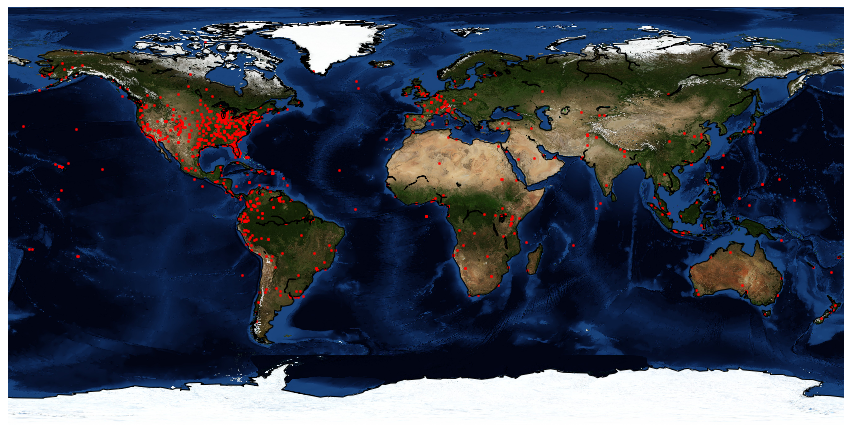

In [29]:
from mpl_toolkits.basemap import Basemap

fig=plt.figure(figsize=(15, 15))

m1 = Basemap('mill',lon_0=0, lat_0=0)
m1.bluemarble()
m1.drawcoastlines()
m1.scatter(lon_, lat_, latlon=True, marker='.', color='r')

#####  Really gathered right? but... where are the airports?

In [30]:
header = ['name', 'city', 'country', 'lat', 'lon']
airports = pd.read_csv('./data/openflights/airports.dat', usecols=(1,2,3,6,7), names=header)
airports.head()

,name,city,country,lat,lon
0,Goroka,Goroka,Papua New Guinea,-6.081689,145.391881
1,Madang,Madang,Papua New Guinea,-5.207083,145.788700
2,Mount Hagen,Mount Hagen,Papua New Guinea,-5.826789,144.295861
3,Nadzab,Nadzab,Papua New Guinea,-6.569828,146.726242
4,Port Moresby Jacksons Intl,Port Moresby,Papua New Guinea,-9.443383,147.220050


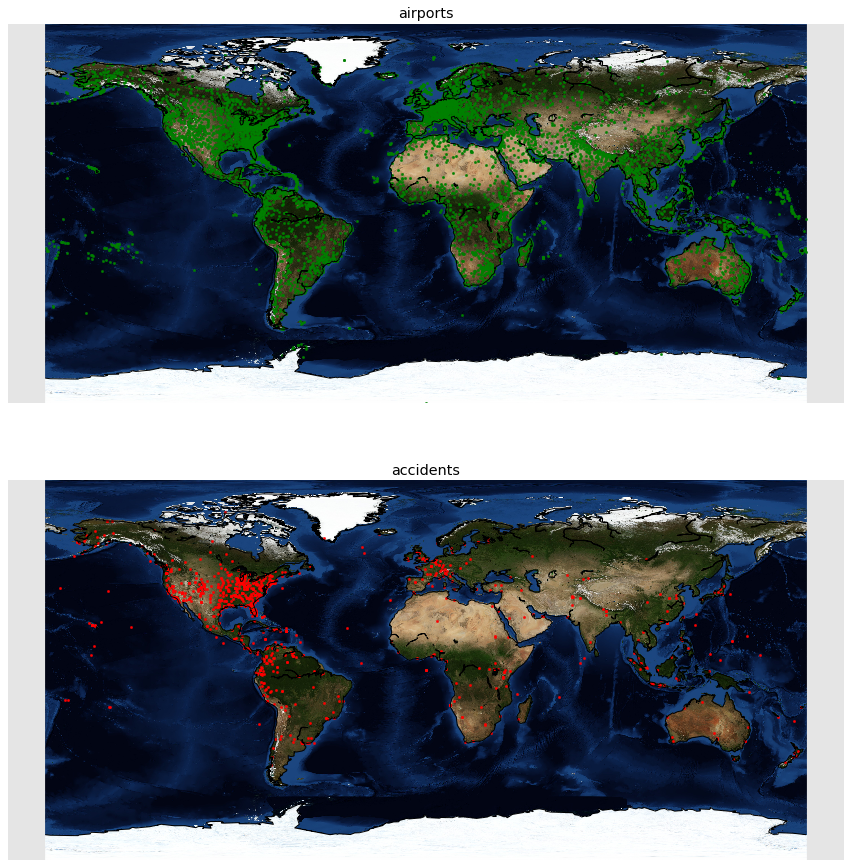

In [31]:
fig, ax = plt.subplots(2, 1, sharex=True, sharey=True)

fig.set_size_inches(15, 15)

ax[0].set_title('airports')
m1 = Basemap('mill',lon_0=0, lat_0=0, ax=ax[0])
m1.drawcoastlines()
m1.bluemarble()
x, y = m1(airports['lon'], airports['lat'])
# retocar para que se vea bien
m1.scatter(x, y, latlon=False, marker='.', color='g')

ax[1].set_title('accidents')
m2 = Basemap('mill',lon_0=0, lat_0=0, ax=ax[1])
m2.drawcoastlines()
m2.bluemarble()
m2.scatter(lon_, lat_, latlon=False, marker='.', color='r')

#### When do accidents occur? Which flight phase is safer?

<img src="./static/PED_phase_flight.jpg" style="width: 800px;"/>

<img src="./static/pict2.png" style="width:700px;"/>

In [32]:
detailed_phase = [501,502,503,504,505,511,512,513,514,
                  521,522,523,531,541,551,552,553,
                  561,562,563,564,565,566,567,567,568,
                  569,571,572,573,574,575,576,581,582,583,
                  591,592, 542]

general_phase = [(ii//10)*10 for ii in detailed_phase[:-1]]
general_phase.append(580)

aircraft['phase_gen'] = aircraft['phase_flt_spec'].replace(to_replace=detailed_phase,
                                                           value=general_phase)

occurrences_series = aircraft['phase_gen'].value_counts()

# Only the ten most common
occurrences_series.iloc[0:10]

570.0    233
540.0    164
520.0    145
510.0    133
0.0      117
500.0    115
560.0    104
550.0    100
530.0     64
580.0     19
Name: phase_gen, dtype: int64

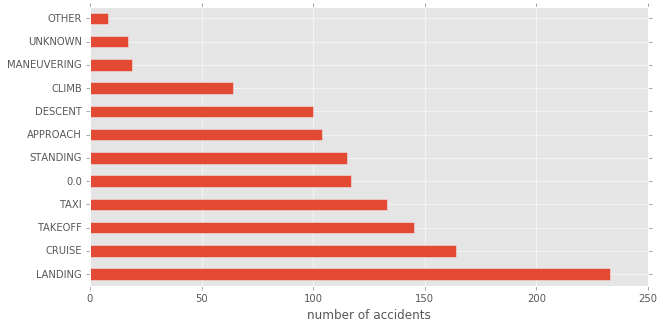

In [33]:
phases_dict = {500:'STANDING',
             510:'TAXI',
             520:'TAKEOFF',
             530:'CLIMB',
             540:'CRUISE',
             550:'DESCENT',
             560:'APPROACH',
             570:'LANDING',
             580:'MANEUVERING',
             600:'OTHER',
             610:'UNKNOWN'}
            
occurrences_series = occurrences_series.rename_axis(phases_dict)

occurrences_series.plot.barh(stacked=True)
plt.xlabel('number of accidents')

In [34]:
aircraft.damage.value_counts()

SUBS    690
NONE    434
DEST    331
MINR    107
UNK       9
Name: damage, dtype: int64

In [35]:
group = aircraft.groupby(['phase_gen', 'damage'])

phases_list = phases_dict.keys()
damage_list = ['NONE', 'SUBS', 'DEST', 'MINR', 'UNK']
injured = ['injured', 'fatalities']
phases = pd.DataFrame(columns=damage_list+injured)

phases

,NONE,SUBS,DEST,MINR,UNK,injured,fatalities


In [36]:
for phase in phases_list:
    sum_inj = 0
    sum_fat = 0
    for dam in damage_list:
        try:
            gg = group.get_group((phase, dam))
            phases.loc[phase, [dam]] = gg['ev_id'].count()
            mask = events['ev_id'].isin(gg['ev_id'])
            #print(mask.sum())
            inj_m = events[mask]['inj_tot_m'].sum()
            inj_s = events[mask]['inj_tot_s'].sum()
            fat = events[mask]['inj_tot_f'].sum()
            if not np.isnan(inj_m):
                sum_inj += inj_m
            if not np.isnan(inj_s):
                sum_inj += inj_s
            if not np.isnan(fat):
                sum_fat += fat
        except KeyError:
            pass
    
    phases.loc[phase, ['injured']] = sum_inj
    phases.loc[phase, ['fatalities']] = sum_fat

phases.rename_axis(phases_dict, inplace=True)
phases

,NONE,SUBS,DEST,MINR,UNK,injured,fatalities
APPROACH,15,31,50,6,2,363,1631
OTHER,2,5,1,NaN,NaN,4,10
CLIMB,29,22,10,3,NaN,162,601
STANDING,41,48,3,23,NaN,261,12
DESCENT,79,2,13,6,NaN,330,145
TAKEOFF,4,76,60,4,1,878,2056
MANEUVERING,1,4,14,NaN,NaN,19,134
LANDING,5,180,35,11,2,1205,739
CRUISE,98,19,34,13,NaN,892,1217
UNKNOWN,NaN,4,13,NaN,NaN,12,38


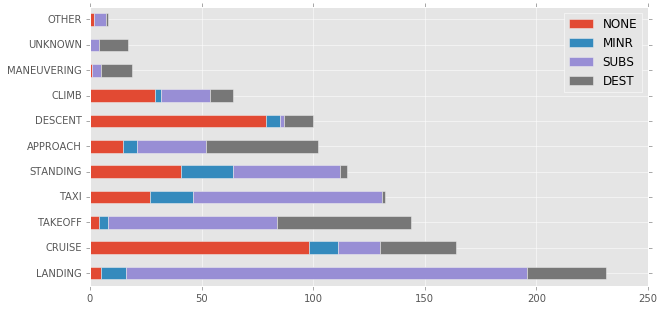

In [37]:
phases['TOTAL'] = phases[['NONE', 'MINR', 'SUBS', 'DEST']].sum(axis=1)
phases = phases.sort_values(by='TOTAL', ascending=False)

phases[['NONE', 'MINR', 'SUBS', 'DEST']].plot.barh(stacked=True)

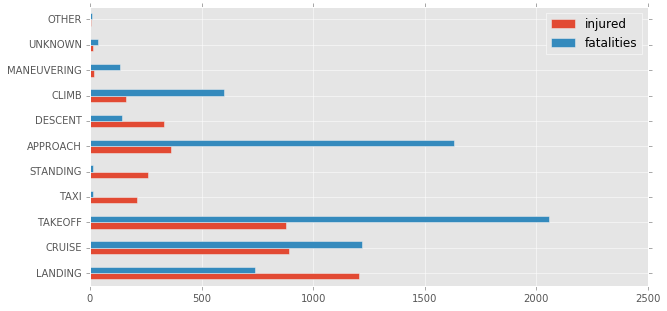

In [38]:
phases[['injured', 'fatalities']].plot.barh()

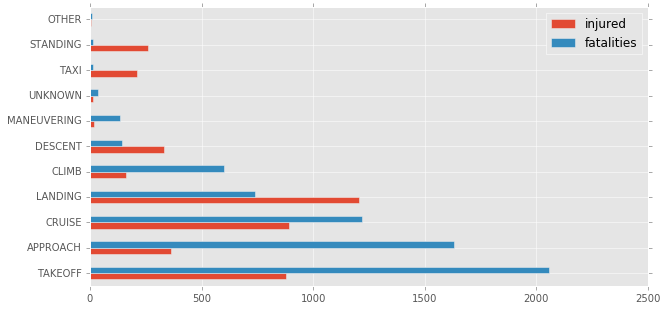

In [39]:
phases = phases.sort_values(by='fatalities', ascending=False)
phases[['injured', 'fatalities']].plot.barh()

#### Which are the main accident occurrences?

In [40]:
occurrences = pd.read_csv("./data/ocurrences.csv", sep=';')
occurrences = occurrences[occurrences['ev_id'].isin(events['ev_id'])]

In [41]:
# ocurrences_filtered['ev_id'].value_counts()
occurrences[occurrences['ev_id']=='20001214X36685']

,ev_id,Aircraft_Key,Occurrence_No,Occurrence_Code,Phase_of_Flight,Altitude,lchg_date,lchg_userid
80803,20001214X36685,1,1,280,551,0,14/12/2000,dbo
80804,20001214X36685,1,2,100,551,0,14/12/2000,dbo
80805,20001214X36685,1,3,430,550,0,14/12/2000,dbo
80806,20001214X36685,2,1,280,541,0,14/12/2000,dbo
80807,20001214X36685,2,2,100,541,0,14/12/2000,dbo
80808,20001214X36685,2,3,130,540,0,14/12/2000,dbo


In [42]:
events[events['ev_id']=='20001214X36685']

,ev_id,ntsb_no,ev_type,ev_date,ev_city,ev_state,ev_country,ev_site_zipcode,mid_air,on_ground_collision,latitude,longitude,latlong_acq,apt_name,ev_nr_apt_id,ev_nr_apt_loc,apt_dist,apt_dir,apt_elev,wx_brief_comp,wx_src_iic,wx_obs_time,wx_obs_dir,wx_obs_fac_id,wx_obs_elev,wx_obs_dist,wx_obs_tmzn,light_cond,sky_cond_nonceil,sky_nonceil_ht,sky_ceil_ht,sky_cond_ceil,vis_rvr,vis_rvv,vis_sm,wx_temp,wx_dew_pt,wind_dir_deg,wind_dir_ind,wind_vel_kts,wind_vel_ind,gust_ind,gust_kts,altimeter,wx_dens_alt,wx_int_precip,metar,ev_highest_injury,inj_f_grnd,inj_m_grnd,inj_s_grnd,inj_tot_f,inj_tot_m,inj_tot_n,inj_tot_s,inj_tot_t,invest_agy,ntsb_docket,ntsb_notf_from,ntsb_notf_date,ntsb_notf_tm,fiche_number,lchg_date,lchg_userid,wx_cond_basic,faa_dist_office,latitude_num,longitude_num
66474,20001214X36685,CHI85FA249,ACC,1985-06-23 17:08:00,SOUTH HAVEN,MI,USA,49090,NaN,NaN,NaN,NaN,NaN,,,OFAP,"0,00000000e+00",0.0,NaN,UNK,PILO,0.0,0.0,,0.0,0.0,,DAYL,UNK,0.0,0.0,UNK,"0,00000000e+00",0.0,"0,00000000e+00",NaN,NaN,0.0,U,0.0,UNK,U,0.0,NaN,NaN,UNK,NaN,SERS,0.0,0.0,0.0,NaN,2.0,71.0,2.0,4.0,N,2474.0,NaN,06/23/1985 12:00:00 AM,0.0,30332,04/09/2001 10:27:21 AM,dbo,VMC,NaN,42.403087,-86.273641


In [43]:
from IPython.display import HTML
HTML('<iframe src="http://www.ntsb.gov/_layouts/ntsb.aviation/brief.aspx?ev_id=20001214X36685&key=2&queryId=9811677a-e5d5-43d4-8d8e-89599d9d47a4&pgno=3&pgsize=50"\
      width="700" height="400"></iframe>')

In [44]:
occurrences['Occurrence_Code'] = occurrences['Occurrence_Code'].replace(
    to_replace=[131,171,172,191,192,193,195,232,271,351,352, 353,351,354],
    value=[130,170,170,190,190,190,190,230,270,520,520,350,350,350])

occurrences_series_2 = occurrences['Occurrence_Code'].value_counts()
occurrences_series_2 = occurrences_series_2[0:13]

In [45]:
occurrences_dict = {130:'AIRFRAME/COMPONENT/SYSTEM FAILURE/MALFUNCTION',
                    170:'FIRE/EXPLOSION',
                    180:'FORCED LANDING',
                    190:'GEAR COLLAPSED',
                    200:'HARD LANDING',
                    220:'IN FLIGHT COLLISION WITH OBJECT',
                    230:'IN FLIGHT COLLISION WITH TERRAIN/WATER',
                    240:'IN FLIGHT ENCOUNTER WITH WEATHER',
                    250:'LOSS OF CONTROL - IN FLIGHT',
                    260:'LOSS OF CONTROL - ON GROUND/WATER',
                    270:'MIDAIR COLLISION',
                    280:'NEAR COLLISION BETWEEN AIRCRAFT',
                    300:'NOSE OVER',
                    310:'ON GROUND/WATER COLLISION WITH OBJECT',
                    320:'ON GROUND/WATER ENCOUNTER WITH TERRAIN/WATER',
                    340:'OVERRUN',
                    350:'LOSS OF ENGINE POWER',
                    430:'MISCELLANEOUS/OTHER',
                    520:'DESCENT'}
            
occurrences_series_2 = occurrences_series_2.rename_axis(occurrences_dict)

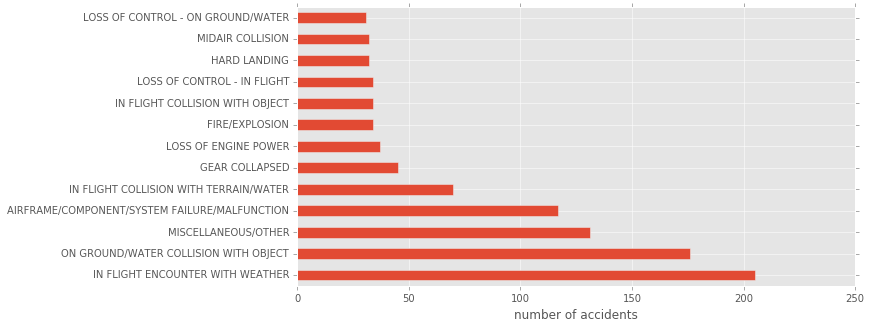

In [46]:
occurrences_series_2.plot.barh(stacked=True)
plt.xlabel('number of accidents')

#### What impact does experience have?

##### Age

In [47]:
flight_crew = pd.read_csv('./data/flight_crew.csv')

# Only crew for the selected events:
flight_crew = flight_crew[flight_crew['ev_id'].isin(events['ev_id'])]
flight_crew.head(5)

,ev_id,Aircraft_Key,crew_no,crew_category,crew_age,crew_sex,crew_city,crew_res_state,crew_res_country,med_certf,med_crtf_vldty,date_lst_med,crew_rat_endorse,crew_inj_level,seatbelts_used,shldr_harn_used,crew_tox_perf,seat_occ_pic,pc_profession,bfr,bfr_date,ft_as_of,lchg_date,lchg_userid,seat_occ_row,infl_rest_inst,infl_rest_depl,child_restraint,med_crtf_limit,mr_faa_med_certf,pilot_flying,available_restraint,restraint_used
41,20140507X51410,1,1,PLT,53.0,NaN,Lexington,SC,USA,CL1,NaN,01/21/2014 12:00:00 AM,NaN,NONE,NaN,NaN,N,LEFT,Y,NaN,02/20/2014 12:00:00 AM,NaN,09/10/2015 05:10:53 PM,lovj,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
42,20140507X51410,1,2,CPLT,43.0,NaN,Sandy,UT,USA,CL1,NaN,03/06/2013 12:00:00 AM,NaN,NONE,NaN,NaN,N,RGT,Y,NaN,NaN,NaN,09/10/2015 04:14:54 PM,lovj,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
144,20030314X00332,1,1,PLT,34.0,M,Raleigh,NC,USA,CL1,VNOW,10/15/2002 12:00:00 AM,Y,NONE,Y,Y,N,LEFT,PCIV,NaN,NaN,NaN,06/02/2004 01:09:06 PM,POWP,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
145,20030314X00332,1,3,CPLT,38.0,M,New Bern,NC,USA,CL2,VWW,09/04/2002 12:00:00 AM,N,NONE,Y,Y,N,RGT,PCIV,NaN,NaN,NaN,06/02/2004 01:09:06 PM,POWP,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
294,20141227X82857,1,1,PLT,NaN,NaN,NaN,NaN,CO,NaN,NaN,NaN,NaN,FATL,NaN,NaN,NaN,LEFT,Y,NaN,NaN,NaN,03/30/2015 10:20:24 AM,kenj,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN


In [48]:
# Remove spaces
flight_crew['crew_category'] = flight_crew['crew_category'].str.strip()

# Pilots and copilots
crew_cat = ['PLT', 'CPLT']
# crew_cat = ['CPLT']
is_plt_cplt = flight_crew['crew_category'].isin(crew_cat)

flight_crew_pc = flight_crew[is_plt_cplt]

flight_crew_pc['crew_age'].describe()

count    1382.000000
mean       44.403039
std         9.583374
min        20.000000
25%        37.000000
50%        45.000000
75%        52.000000
max        68.000000
Name: crew_age, dtype: float64

([<matplotlib.axis.XTick at 0x7fe9eb17b1d0>],
 <a list of 1 Text xticklabel objects>)

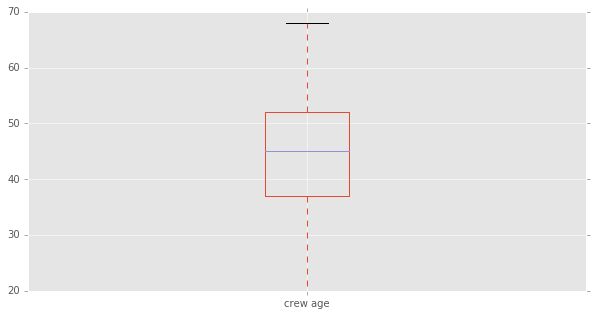

In [49]:
flight_crew_pc['crew_age'].plot.box()
plt.xticks([1],['crew age'])

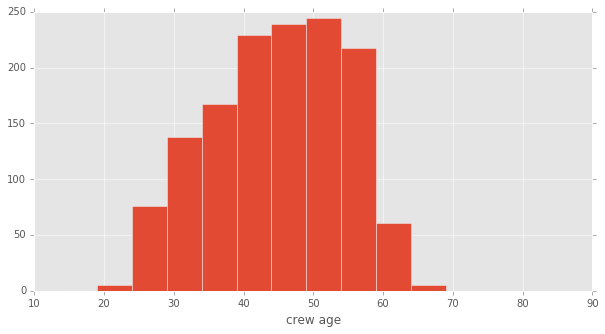

In [50]:
bins = np.arange(14, 85, 5)
flight_crew_pc['crew_age'].hist(bins=bins)
plt.xlabel('crew age')

According to GAMMA databook:
    http://www.gama.aero/files/GAMA_2015_Databook_LoRes%20updated%203-29-2016.pdf
    http://www.gama.aero/media-center/industry-facts-and-statistics/statistical-databook-and-industry-outlook#year2015

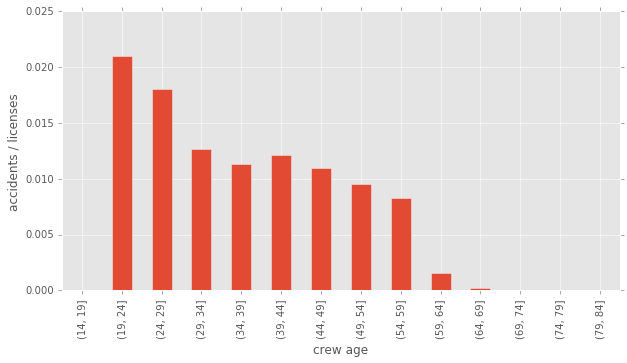

In [51]:
licenses_by_age_airline = np.array([0, 572, 5199, 12003, 15507,
                                                          18337, 23058, 25882, 24220, 16824,
                                                          10184, 4284, 1766, 787])

age_group = pd.cut(flight_crew_pc['crew_age'], bins)
gby_age = flight_crew_pc['ev_id'].groupby(age_group).count()

accident_rate_age = gby_age / licenses_by_age_airline
accident_rate_age.plot.bar()
plt.ylabel('accidents / licenses')
plt.xlabel('crew age')

It seems that some people have investigated this issue before:
>  [...] the accident rate of airline transport
rated (ATR) pilots aged 55–59 (3.78/1,000) is approximately one-third of that of pilots with the
same rating who are aged 20–24 (11.71/10,000). <cite>John A. Wise, V. David Hopkin, Daniel J. Garland, **Handbook of Aviation Human Factors**, Second Edition.</cite>

##### Flight hours

In [52]:
flight_time = pd.read_csv('./data/flight_time.csv', sep=';', usecols=(0,1,2,3,4,5))
cond = flight_time['ev_id'].isin(events['ev_id'])
flight_time = flight_time[cond]

flight_time['flight_type'] = flight_time['flight_type'].str.split().str[0]
flight_time['flight_craft'] = flight_time['flight_craft'].str.split().str[0]

In [53]:
flight_type = list(flight_time.groupby('flight_type').groups.keys())
print(flight_type)

['NO', 'PIC', 'L24H', 'INST', 'IRCV', 'L30D', 'L90D', 'TOTL']


In [54]:
flight_craft = list(flight_time.groupby('flight_craft').groups.keys())
print(flight_craft)

['ROTO', 'INC', 'LTA', 'ALL', 'NGHT', 'ACTU', 'MENG', 'SIMU', 'SENG', 'GLDR', 'REL', 'MAKE']


In [55]:
gby_flight_time = flight_time.groupby(['flight_craft', 'flight_type'])

In [56]:
from ipywidgets import interact

In [57]:
def my_widget_function(fcraft, ftype, factor):
    flight_h = gby_flight_time.get_group((fcraft, ftype))['flight_hours']
    print(flight_h.describe())
    max_v = flight_h
    cond = flight_h < factor *  flight_h.max()
    
    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    flight_h[cond].hist(ax=ax[0])
    ax[0].set_ylabel('flight hours')
    flight_h[cond].plot.box(ax=ax[1])

count      402.000000
mean      7417.089552
std       5572.552277
min          0.000000
25%       2976.250000
50%       6108.500000
75%      10781.750000
max      24400.000000
Name: flight_hours, dtype: float64


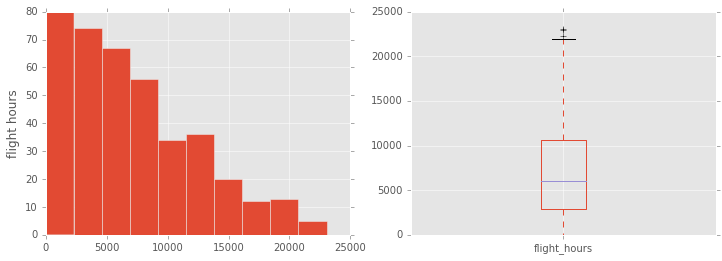

In [58]:
interact(my_widget_function,
         fcraft=flight_craft,
         ftype=flight_type,
         factor=(0., 1., 0.05))

---
Is there a limit on flight hours per year?

http://aviation.stackexchange.com/questions/1807/what-is-common-number-of-flight-hours-a-year-for-an-airline-pilot


#### And finally... is commercial air transport safer now than 30 years ago?

In [60]:
ev_before_2016 = events[events['ev_date'].dt.year < 2016]
gby_year = events.groupby(ev_before_2016.ev_date.dt.year)

injured_per_year = gby_year[['inj_tot_f', 'inj_tot_s', 'inj_tot_m']].count()

injured_per_year.tail()

,inj_tot_f,inj_tot_s,inj_tot_m
ev_date,,,
2011.0,9,24,8
2012.0,5,17,7
2013.0,8,9,4
2014.0,8,17,9
2015.0,4,17,7


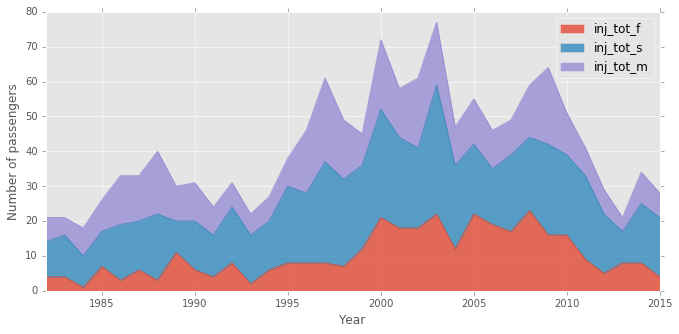

In [61]:
injured_per_year.plot.area(alpha=0.8, figsize=(11,5))
plt.xlabel('Year')
plt.ylabel('Number of passengers')

https://en.wikipedia.org/wiki/List_of_accidents_and_incidents_involving_commercial_aircraft#1999

In [62]:
passengers = pd.read_csv('./data/annual_passengers_carried/data.csv', nrows=1, usecols=range(4,60))
passengers = passengers.transpose()
# renaming column
passengers.columns = ['passengers']
# parsing date in index 
passengers.index = pd.to_datetime(passengers.index.str[:4])
# converting flight number to number
passengers['passengers'] = pd.to_numeric(passengers['passengers'], errors='coerce') / 1e6
passengers.index = passengers.index.year

In [63]:
flights = pd.read_csv('./data/annual_worldwide_departures/data.csv', nrows=1, usecols=range(4,59))
flights = flights.transpose()
# renaming column
flights.columns = ['flights']
flights
# parsing date in index 
flights.index = pd.to_datetime(flights.index.str[:4])
# converting flight number to number
flights['flights'] = pd.to_numeric(flights['flights'], errors='coerce') / 1e6

flights.index = np.arange(1960,2015)

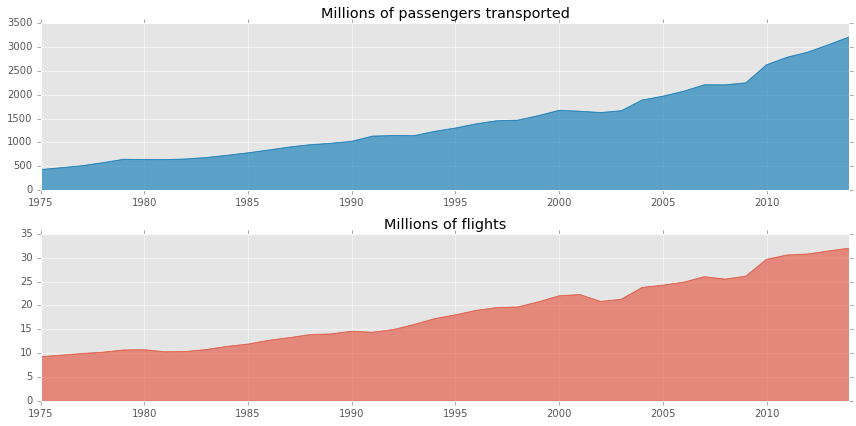

In [64]:
fig, ax = plt.subplots(2, 1, figsize=(12,6))
ax[0].set_title('Millions of passengers transported')
passengers['passengers'].plot.area(ax=ax[0], alpha=0.6, color="#0072B2")
ax[0].set_xlim(1975, 2014)

ax[1].set_title('Millions of flights')
flights['flights'].plot.area(ax=ax[1], alpha=0.6)
ax[1].set_xlim(1975, 2014)

plt.tight_layout()

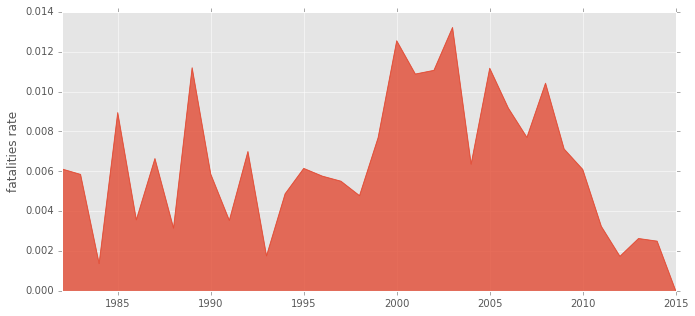

In [65]:
letality_rate = injured_per_year['inj_tot_f'] / passengers['passengers']
ax = letality_rate.plot.area(alpha=0.8, figsize=(11,5))
ax.set_xlim(1982, 2015)

ax.set_ylabel('fatalities rate')

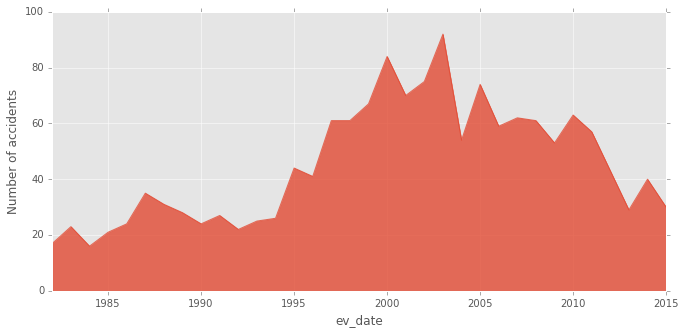

In [66]:
accidents_gby_year = events['ev_id'].groupby(events.ev_date.dt.year).count()
ax = accidents_gby_year.plot.area(alpha=0.8, figsize=(11,5))
ax.set_xlim(1982, 2015)

ax.set_ylabel('Number of accidents')

In [67]:
accident_rate = accidents_gby_year / flights.flights
accident_rate.tail()

2012    1.397407
2013    0.923342
2014    1.250260
2015         NaN
2016         NaN
dtype: float64

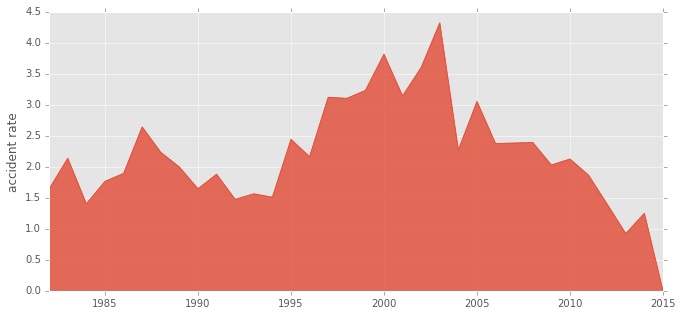

In [68]:
ax = accident_rate.plot.area(alpha=0.8, figsize=(11,5))
ax.set_xlim(1982, 2015)
ax.set_ylabel('accident rate')

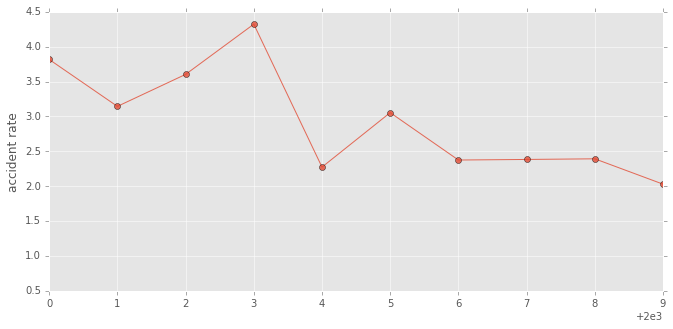

In [69]:
ax = accident_rate.plot(alpha=0.8, figsize=(11,5), marker='o')
ax.set_xlim(2000, 2009)
ax.set_ylabel('accident rate')

![FAA](./static/FAA.png)

![PyData_logo](./static/pydata-logo-madrid-2016.png)


---


In [1]:
# Notebook style
from IPython.core.display import HTML
css_file = './static/style.css'
HTML(open(css_file, "r").read())